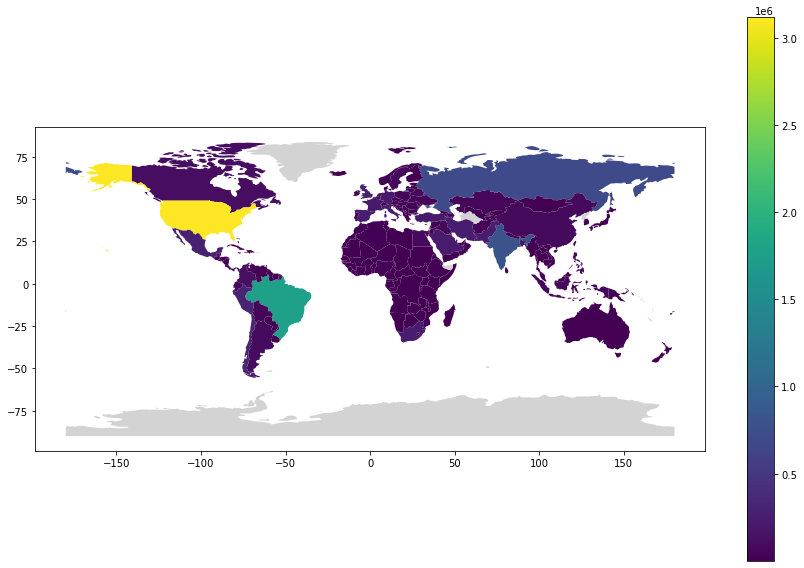

In [16]:
import scipy.optimize as optim
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import random
import requests

# importar os dados do covid e fazer o tratamento dos dados pro brasil e estimar uma curva de infectados com base no modelo

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

covid_data = pd.read_csv(url,error_bad_lines=False). \
        melt(  id_vars = ['Country/Region','Province/State','Lat','Long'],
               value_name = "Cases",
               var_name   = "Date"). \
        rename( columns = {'Country/Region':'Country',
                           'Province/State':'State'} )
        

br_data = covid_data.query("Country == 'Brazil'" )

br_covid = br_data.set_index(np.array(pd.to_datetime(br_data['Date']))). \
            assign( Dys_1st_case = [i for i in range(0,len(br_data))] )
# Constroi data set com a ultima visão relacionada a casos

de_para_pais = pd.read_csv(r"C:\Users\yurim\Desktop\COVID\de_para_pais.csv",sep=';', encoding='ISO-8859-1')


world_data = covid_data.loc[ covid_data['Date'] == max(covid_data['Date']), ['Country','Cases']]. \
             merge( de_para_pais, how = 'left', left_on = 'Country', right_on = 'DATA')

world_data.loc[ world_data['DATA'].isna(), 'MAP'] = world_data.loc[ world_data['DATA'].isna(), 'Country']

world_data = world_data.groupby('MAP',as_index=False)['Cases'].agg('sum')

# Através do pacote geopandas ttraz informações espaciais sobre mapa mundi

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

# cruza informações

world_c = world.merge( world_data, how='left', left_on = 'name', right_on = 'MAP'). \
          drop('MAP', axis = 1)
            
world_c.plot( column = 'Cases', legend = True, figsize=(15, 10),missing_kwds={"color":"lightgrey","label":"Missing Data"})


Text(0.5, 1.0, 'Casos por 100 mil habitantes - Relação por UF')

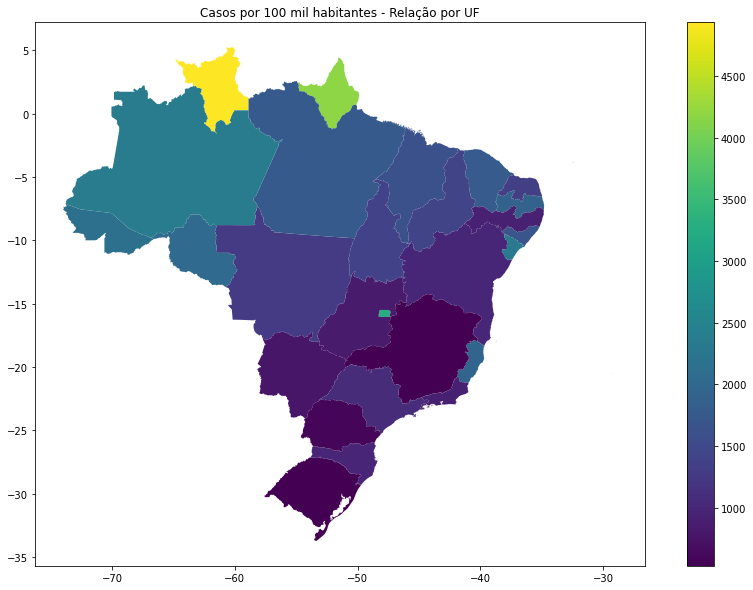

In [18]:
#meso_sp = gp.read_file(r"C:\Users\yurim\Desktop\COVID\Shapefile\35MEE250GC_SIR.shp")

def download_open(url):
    
    filename = url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    
    return pd.read_csv(filename)

raw_data = download_open("https://data.brasil.io/dataset/covid19/caso_full.csv.gz")

var = ['state','city_ibge_code','date','last_available_confirmed_per_100k_inhabitants','last_available_confirmed','new_confirmed']

state_data = raw_data.loc[ raw_data['place_type'] == 'state' , var ]. \
             assign( CD_IBGE = lambda x: x['city_ibge_code'].astype(str).str[:-2] ). \
             drop( 'city_ibge_code', axis = 1)


data_base = pd.DataFrame( [ [state_data['state'].unique()[i],state_data['date'].unique()[j]] 
                             for i in range(0,len(state_data['state'].unique())) 
                             for j in range(0,len(state_data['date'].unique())) ], 
                          columns = ['Estado','Data']). \
            merge( state_data, how = "left", left_on = ["Estado","Data"] , right_on = ["state","date"]). \
            fillna(0)

brasil_map = gp.read_file(r"C:\Users\yurim\Desktop\COVID\Shapefile\BRUFE250GC_SIR.shp"). \
             merge( data_base.loc[ data_base['Data'] == max(data_base['Data']),:], 
                   how = "left", 
                   left_on = 'CD_GEOCUF',
                   right_on = 'CD_IBGE' )

brasil_map.plot( column = 'last_available_confirmed_per_100k_inhabitants', 
              legend = True, figsize=(15, 10))
plt.title("Casos por 100 mil habitantes - Relação por UF")

Text(0.5, 1.0, 'Casos por 100 mil habitantes - Estado de São Paulo')

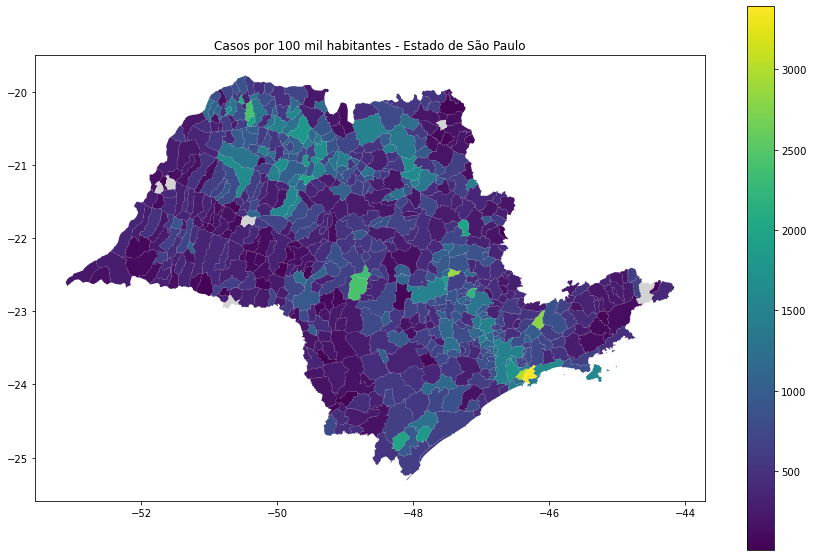

In [19]:
br_det_data = raw_data. \
              query("state == 'SP' & place_type != 'state'"). \
              assign( CD_IBGE = lambda x: x['city_ibge_code'].astype(str).str[:-2])

br_det_data_2 = br_det_data.loc[ br_det_data['date'] == max(br_det_data['date'])  ,:]

muni_sp = gp.read_file(r"C:\Users\yurim\Desktop\COVID\Shapefile\35MUE250GC_SIR.shp"). \
          merge( br_det_data_2, how="left", left_on="CD_GEOCMU", right_on="CD_IBGE")


muni_sp.plot( column = 'last_available_confirmed_per_100k_inhabitants', 
              legend = True, figsize=(15, 10),
              missing_kwds={"color":"lightgrey","label":"Missing Data"} )
plt.title("Casos por 100 mil habitantes - Estado de São Paulo")

Text(0.5, 1.0, 'Casos novos diarios no municipio de São Paulo')

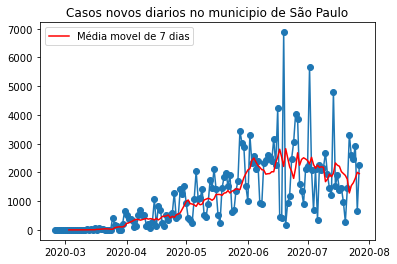

In [29]:

# Analisa dados do municipio de São Paulo

sp_muni_dt = br_det_data[ br_det_data['city'] == "São Paulo" ]

#plt.plot( np.array( sp_muni_dt['date']) , np.array(  sp_muni_dt['last_available_confirmed'] ) )

date_vec  = [ np.array(sp_muni_dt['date'])[i]                       for i in range(7,len(sp_muni_dt)) ]
sev_dy_av = [ np.mean(np.array(sp_muni_dt['new_confirmed'])[i-7:i]) for i in range(7,len(sp_muni_dt)) ]

plt.plot( pd.Series( np.array(  sp_muni_dt['new_confirmed'] ), index = pd.to_datetime(np.array( sp_muni_dt['date'])) ) )
plt.scatter( pd.to_datetime(np.array( sp_muni_dt['date'])) , np.array(  sp_muni_dt['new_confirmed'] ) )
plt.plot( pd.Series( sev_dy_av ,index = pd.to_datetime(date_vec)),'r', label = 'Média movel de 7 dias')
plt.legend()
plt.title("Casos novos diarios no municipio de São Paulo")


In [22]:
rm_sp = ['São Paulo', 'Arujá', 'Barueri', 'Biritiba Mirim','Caieiras', 'Cajamar', 'Carapicuíba','Cotia','Diadema','Embu',
        'Embu-Guaçu','Ferraz de Vasconcelos','Francisco Morato','Franco da Rocha','Guararema','Guarulhos','Itapecerica da Serra',
        'Itapevi','Itaquaquecetuba','Jandira','Juquitiba','Mairiporã','Mauá','Mogi das Cruzes','Osasco','Pirapora do Bom Jesus',
        'Poá','Ribeirão Pires','Rio Grande da Serra','Salesópolis','Santa Isabel','Santana do Parnaíba','Santo André',
        'São Bernardo do Campo','São Caetano do Sul','São Lourenço da Serra Suzano','Suzano','Taboão da Serra','Vargem Grande Paulista']

rm_sp_data = br_det_data.loc[ br_det_data['city'].isin(rm_sp),:]





TypeError: object of type 'method' has no len()

In [28]:
#len( rm_sp_data['city'].unique() )



39